In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
import os
import scanpy as sc
from scipy.spatial.distance import squareform
import numpy as np

Load the dataframe that contains the assignment of HPCs to each cn-HPC tile.

In [3]:
cn_overlap_file = "/gpfs/scratch/leh06/NivoPembro_Results/cn_hpc_df_overlap.csv"
df = pd.read_csv(cn_overlap_file)
print(df.head())

                     hist_subtype  indexes  labels original_set  \
0  224px_tcga_luad_cell_0.504umpx        1       1        train   
1  224px_tcga_luad_cell_0.504umpx        2       1        train   
2  224px_tcga_luad_cell_0.504umpx        3       1        train   
3  224px_tcga_luad_cell_0.504umpx        5       1        train   
4  224px_tcga_luad_cell_0.504umpx        6       1        train   

   os_event_data  os_event_ind                        patterns     samples.x  \
0      18.673973             0  224px_tcga_luad_cell_0.504umpx  TCGA-97-8171   
1       5.687671             1  224px_tcga_luad_cell_0.504umpx  TCGA-78-7146   
2      31.298630             1  224px_tcga_luad_cell_0.504umpx  TCGA-55-7227   
3       9.961644             1  224px_tcga_luad_cell_0.504umpx  TCGA-05-4396   
4      21.435616             0  224px_tcga_luad_cell_0.504umpx  TCGA-55-7726   

                    slides           tiles  leiden_1.0    tiles_20x  \
0  TCGA-97-8171-01Z-00-DX1  154_59_32.jpeg   

In [8]:
# Create a color map for HPCs
global_labels = sorted(df["leiden_1.0"].unique())
cmap = matplotlib.colormaps["tab10"]
global_color_map = {label: cmap(i/float(len(global_labels))) for i, label in enumerate(global_labels)}
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom_bwr", ["blue", "white", "red"], N=256
)

In [18]:
def parse_tile_coords(tile_name, tile_size=224):
    """
    Extracts tile indices from a filename in the format "x_y.jpeg"
    and converts them to pixel coordinates by multiplying by tile_size.
    """
    base = tile_name.split('.')[0]
    parts = base.split('_')
    if len(parts) != 2:
        raise ValueError("Tile name doesn't follow the expected 'x_y.jpeg' format.")
    x_idx, y_idx = map(int, parts)
    return x_idx * tile_size, y_idx * tile_size

def compute_centroids(df_group, tile_size=224):
    """
    Group 20× tiles in one 5× tile by cn-HPC label, compute centroids and counts.
    Returns (centroids, counts, cn_hpc_coords).
    """
    cn_hpc_coords = {}
    for _, row in df_group.iterrows():
        x, y = parse_tile_coords(row["tiles_20x"], tile_size)
        label = row["leiden_1.0"]
        cn_hpc_coords.setdefault(label, []).append((x, y))
    centroids = {lbl: np.mean(coords, axis=0) for lbl, coords in cn_hpc_coords.items()}
    counts    = {lbl: len(coords)        for lbl, coords in cn_hpc_coords.items()}
    return centroids, counts, cn_hpc_coords

def build_graph_for_5x_tile(df_group, tile_size=224):
    """
    Build a graph for one 5× tile: nodes=cn-HPC, edges=freq>0.
    """
    centroids, counts, cn_hpc_coords = compute_centroids(df_group, tile_size)
    G = nx.Graph()
    # add nodes with pos & count
    for lbl, pos in centroids.items():
        G.add_node(lbl, pos=pos, count=counts[lbl])

    labels = list(cn_hpc_coords)
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            l1, l2 = labels[i], labels[j]
            # now simply count all possible cross‐cluster pairs:
            freq = len(cn_hpc_coords[l1]) * len(cn_hpc_coords[l2])
            if freq > 0:
                G.add_edge(l1, l2, weight=freq)
    return G

def average_graphs(graph_list):
    """
    Average adjacency matrices of a list of graphs.
    Returns (all_nodes, avg_adj).
    """
    all_nodes = sorted({n for G in graph_list for n in G.nodes})
    n = len(all_nodes)
    adj_sum = np.zeros((n,n))
    cnt     = np.zeros((n,n))
    idx     = {lbl:i for i,lbl in enumerate(all_nodes)}
    for G in graph_list:
        for u,v,data in G.edges(data=True):
            i,j = idx[u], idx[v]
            w = data.get('weight',1)
            adj_sum[i,j] += w
            adj_sum[j,i] += w
            cnt[i,j] += 1
            cnt[j,i] += 1
    avg_adj = np.divide(adj_sum, cnt, out=np.zeros_like(adj_sum), where=cnt>0)
    return all_nodes, avg_adj

def run_graph_analysis(hpc, df, global_color_map,
                       freq_percentile=80, plot_individual = False, 
                       plot_consensus = True):
    """
    Visualize 10 random 5×-tile graphs and the consensus graph for HPC.
    Returns (all_nodes, avg_adj) for downstream heatmapping.
    """
    df_hpc = df[df["HPC"]==hpc]
    tile_groups = df_hpc.groupby("tiles_5x")

    # 1) Build ALL graphs for consensus
    all_graphs = [
        build_graph_for_5x_tile(grp, tile_size=224)
        for _,grp in tile_groups
    ]

    # 2) Sample 10 for individual plotting
    sample = random.sample(list(tile_groups.groups), min(10, len(tile_groups)))
    tile_graphs = {tn: all_graphs[i] for i,tn in enumerate(tile_groups.groups) if tn in sample}

    # --- Plot individual 5×-tile graphs ---
    if plot_individual:
        fig,axes = plt.subplots(2,5,figsize=(15,6))
        axes = axes.flatten()
        for ax,(tn,G) in zip(axes, tile_graphs.items()):
            pos = nx.get_node_attributes(G,'pos')
            sizes = [G.nodes[l]['count']*150 for l in G.nodes]
            cols  = [global_color_map[l]      for l in G.nodes]
            w     = [G.edges[e]['weight']*1.0 for e in G.edges]
            nx.draw(G,pos,with_labels=True,node_size=sizes,node_color=cols,
                    width=w,edge_color='black',ax=ax,edgecolors='black',linewidths=1)
            ax.set_title(f"Tile: {tn}")
        plt.tight_layout()
        plt.show()

    # 3) Consensus adjacency + filtering
    all_nodes, avg_adj = average_graphs(all_graphs)
    # apply percentile filter
    i1,j1 = np.triu_indices_from(avg_adj, k=1)
    flat = avg_adj[i1,j1]
    nz   = flat[flat>0]
    if len(nz)>0:
        cutoff = np.percentile(nz, freq_percentile)
        avg_adj[avg_adj<cutoff] = 0
    

    # 4) Build consensus graph
    Gc = nx.Graph()
    for lbl in all_nodes:
        poses  = [G.nodes[lbl]['pos'] for G in all_graphs if lbl in G.nodes]
        counts = [G.nodes[lbl]['count'] for G in all_graphs if lbl in G.nodes]
        if poses:
            Gc.add_node(lbl,
                        pos=np.mean(poses,axis=0),
                        count=np.mean(counts))
    n = len(all_nodes)
    for i in range(n):
        for j in range(i+1,n):
            w = avg_adj[i,j]
            if w>0:
                Gc.add_edge(all_nodes[i],all_nodes[j],avg_weight=w)

    # 5) Plot consensus graph
    if plot_consensus:
        pos = nx.get_node_attributes(Gc,'pos')
        sizes = [Gc.nodes[l]['count']*250 for l in Gc.nodes]
        cols  = [global_color_map[l]     for l in Gc.nodes]
        wts   = [Gc.edges[e]['avg_weight']*0.4 for e in Gc.edges]
        plt.figure(figsize=(8,6))
        nx.draw(Gc,pos,with_labels=True,node_size=sizes,node_color=cols,
                width=wts,edge_color='black',edgecolors='black',linewidths=1)
        plt.title(f"Consensus (Average) Graph for HPC: {hpc}")
        plt.show()

    return all_nodes, avg_adj

def compare_adjacency_matrices_filtered(labels1, adj1,
                                        labels2, adj2,
                                        title1="HPC 1",
                                        title2="HPC 2",
                                        title3="Difference",
                                        cmap="Reds",
                                        diff_cmap="coolwarm"):
    """
    1) Filters out any cn-HPC that has no edges (all-zero row+col in adj).
    2) Builds the union of the filtered label sets.
    3) Embeds each matrix into that union.
    4) Computes the difference matrix.
    5) Clusters based on the difference matrix but forces cnHPC23 first.
    6) Plots three heatmaps side by side.
    """
    def filtered_labels_and_matrix(labels, adj):
        row_sums = adj.sum(axis=1) + adj.sum(axis=0)
        keep = [lab for lab, s in zip(labels, row_sums) if s > 0]
        idx = {lab: i for i, lab in enumerate(labels)}
        n_f = len(keep)
        mat_f = np.zeros((n_f, n_f))
        for i_f, u in enumerate(keep):
            for j_f, v in enumerate(keep):
                mat_f[i_f, j_f] = adj[idx[u], idx[v]]
        return keep, mat_f

    # 1. Filter each
    lab1_f, mat1_f = filtered_labels_and_matrix(labels1, adj1)
    lab2_f, mat2_f = filtered_labels_and_matrix(labels2, adj2)

    # 2. Union of filtered labels
    union = sorted(set(lab1_f) | set(lab2_f))
    n = len(union)
    idx_u = {lab: i for i, lab in enumerate(union)}

    # 3. Embed each into the union
    full1 = np.zeros((n, n))
    for i, u in enumerate(lab1_f):
        for j, v in enumerate(lab1_f):
            full1[idx_u[u], idx_u[v]] = mat1_f[i, j]
    full2 = np.zeros((n, n))
    for i, u in enumerate(lab2_f):
        for j, v in enumerate(lab2_f):
            full2[idx_u[u], idx_u[v]] = mat2_f[i, j]

    # 4. Compute difference matrix
    diff = full1 - full2

    # 5. Cluster difference matrix
    # (Add tiny noise to avoid identical rows)
    diff_perturbed = diff + np.random.normal(scale=1e-6, size=diff.shape)
    linkage_result = linkage(diff_perturbed, method='average')
    cluster_order = leaves_list(linkage_result)

    # Map back to labels
    ordered_labels = [union[i] for i in cluster_order]

    # Force '23' to the top
    cnHPC23_label = 23
    if cnHPC23_label in ordered_labels:
        ordered_labels = [cnHPC23_label] + [lab for lab in ordered_labels if lab != cnHPC23_label]

    # 6. Create reordered matrices
    idx_order = [union.index(lab) for lab in ordered_labels]

    full1_ordered = full1[np.ix_(idx_order, idx_order)]
    full2_ordered = full2[np.ix_(idx_order, idx_order)]
    diff_ordered  = diff[np.ix_(idx_order, idx_order)]

    # 7. Plot
    
    fig, axes = plt.subplots(
        1, 3,
        figsize=(3 * n * 0.3 + 6, 3 * n * 0.3 + 4),
        constrained_layout=True
    )

    matrices = [full1_ordered, full2_ordered, diff_ordered]
    titles = [title1, title2, title3]
    cmaps = [cmap, cmap, diff_cmap]

    vmax = max(full1.max(), full2.max())
    abs_max = np.max(np.abs(diff_ordered))
    vmin_diff, vmax_diff = -abs_max, abs_max

    for ax, mat, title, cmap_now in zip(axes, matrices, titles, cmaps):
        if title == title3:
            im = ax.imshow(mat, cmap=cmap_now, vmin=vmin_diff, vmax=vmax_diff, interpolation="nearest")
        else:
            im = ax.imshow(mat, cmap=cmap_now, vmin=0, vmax=vmax, interpolation="nearest")

        ax.set_title(title, pad=12, fontsize=20, weight="bold")

        ax.set_xticks(np.arange(n))
        ax.set_yticks(np.arange(n))

        prefixed = [f"cnHPC{lab}" for lab in ordered_labels]
        ax.set_xticklabels(prefixed, rotation=90, fontsize=20)
        ax.set_yticklabels(prefixed, fontsize=20)

        ax.tick_params(which='both', length=0)

        ax.set_xticks(np.arange(-.5, n, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n, 1), minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)

        for spine in ax.spines.values():
            spine.set_visible(False)

    # One shared colorbar
    cbar = fig.colorbar(
        im, ax=axes.ravel().tolist(),
        fraction=0.046, pad=0.04, shrink=0.3
    )
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(
        "Interaction difference",
        rotation=270, labelpad=20, fontsize=20
    )

    plt.show()


def plot_clustered_heatmap(matrix, labels, title, save_path,
                           cmap="Reds", vmax=None, fontsize=10):
    """
    Plots and saves a clustered square heatmap of the full interaction matrix.
    
    Parameters:
        matrix     : 2D square numpy array (e.g., full1 or full2)
        labels     : list of cluster IDs corresponding to matrix rows/cols
        title      : title of the heatmap (e.g., "HPC 1")
        save_path  : full path to save the figure
        cmap       : matplotlib colormap (default: Reds)
        vmax       : optional fixed max for color scaling
        fontsize   : font size for tick labels
    """

    n = len(labels)
    vmax = vmax if vmax is not None else matrix.max()

    # Plotting
    fig, ax = plt.subplots(figsize=(n * 0.3 + 2, n * 0.3 + 2))
    im = ax.imshow(matrix, cmap=cmap, vmin=0, vmax=vmax, interpolation="nearest")

    ax.set_title(title, pad=12, fontsize=14, weight="bold")

    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels([f"cnHPC{lab}" for lab in labels], rotation=90, fontsize=fontsize)
    ax.set_yticklabels([f"cnHPC{lab}" for lab in labels], fontsize=fontsize)
    ax.tick_params(which='both', length=0)

    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=0.5)

    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.5)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label("Interaction Frequency", rotation=270, labelpad=20, fontsize=fontsize+2)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved clustered heatmap to: {save_path}")

Run graph analysis for HPC of interest.

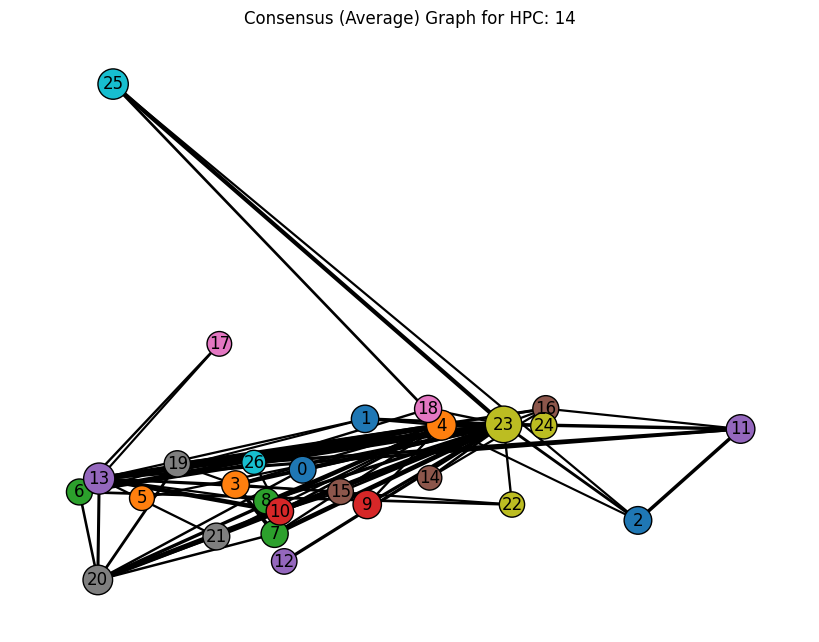

In [19]:
# HPC 14
nodes_hpc14, adj_hpc14 = run_graph_analysis(
    14, df, global_color_map,
    freq_percentile=80)

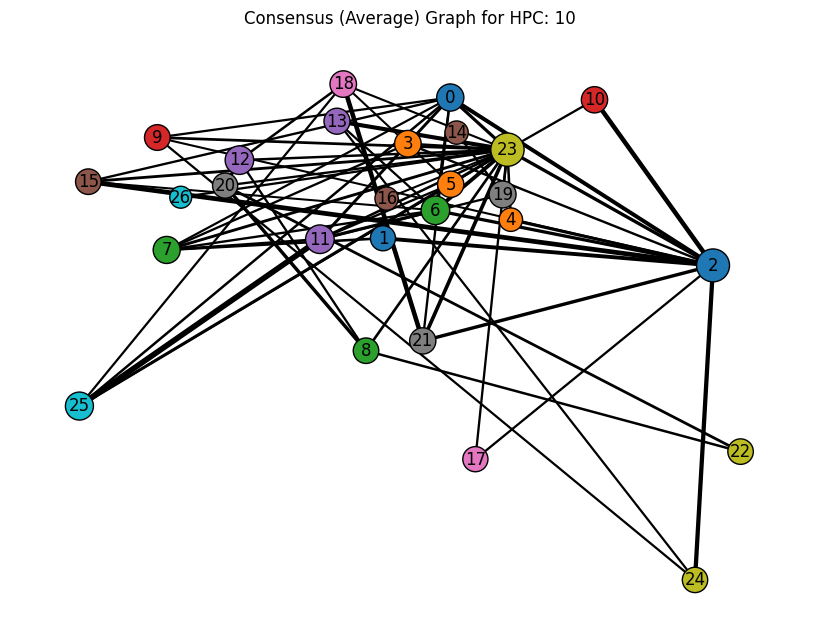

In [13]:
# HPC 10
nodes_hpc10, adj_hpc10 = run_graph_analysis(
    10, df, global_color_map,
    freq_percentile=80
)

Compare interaction heatmaps (fingerprint) between 2 HPCs of interest.

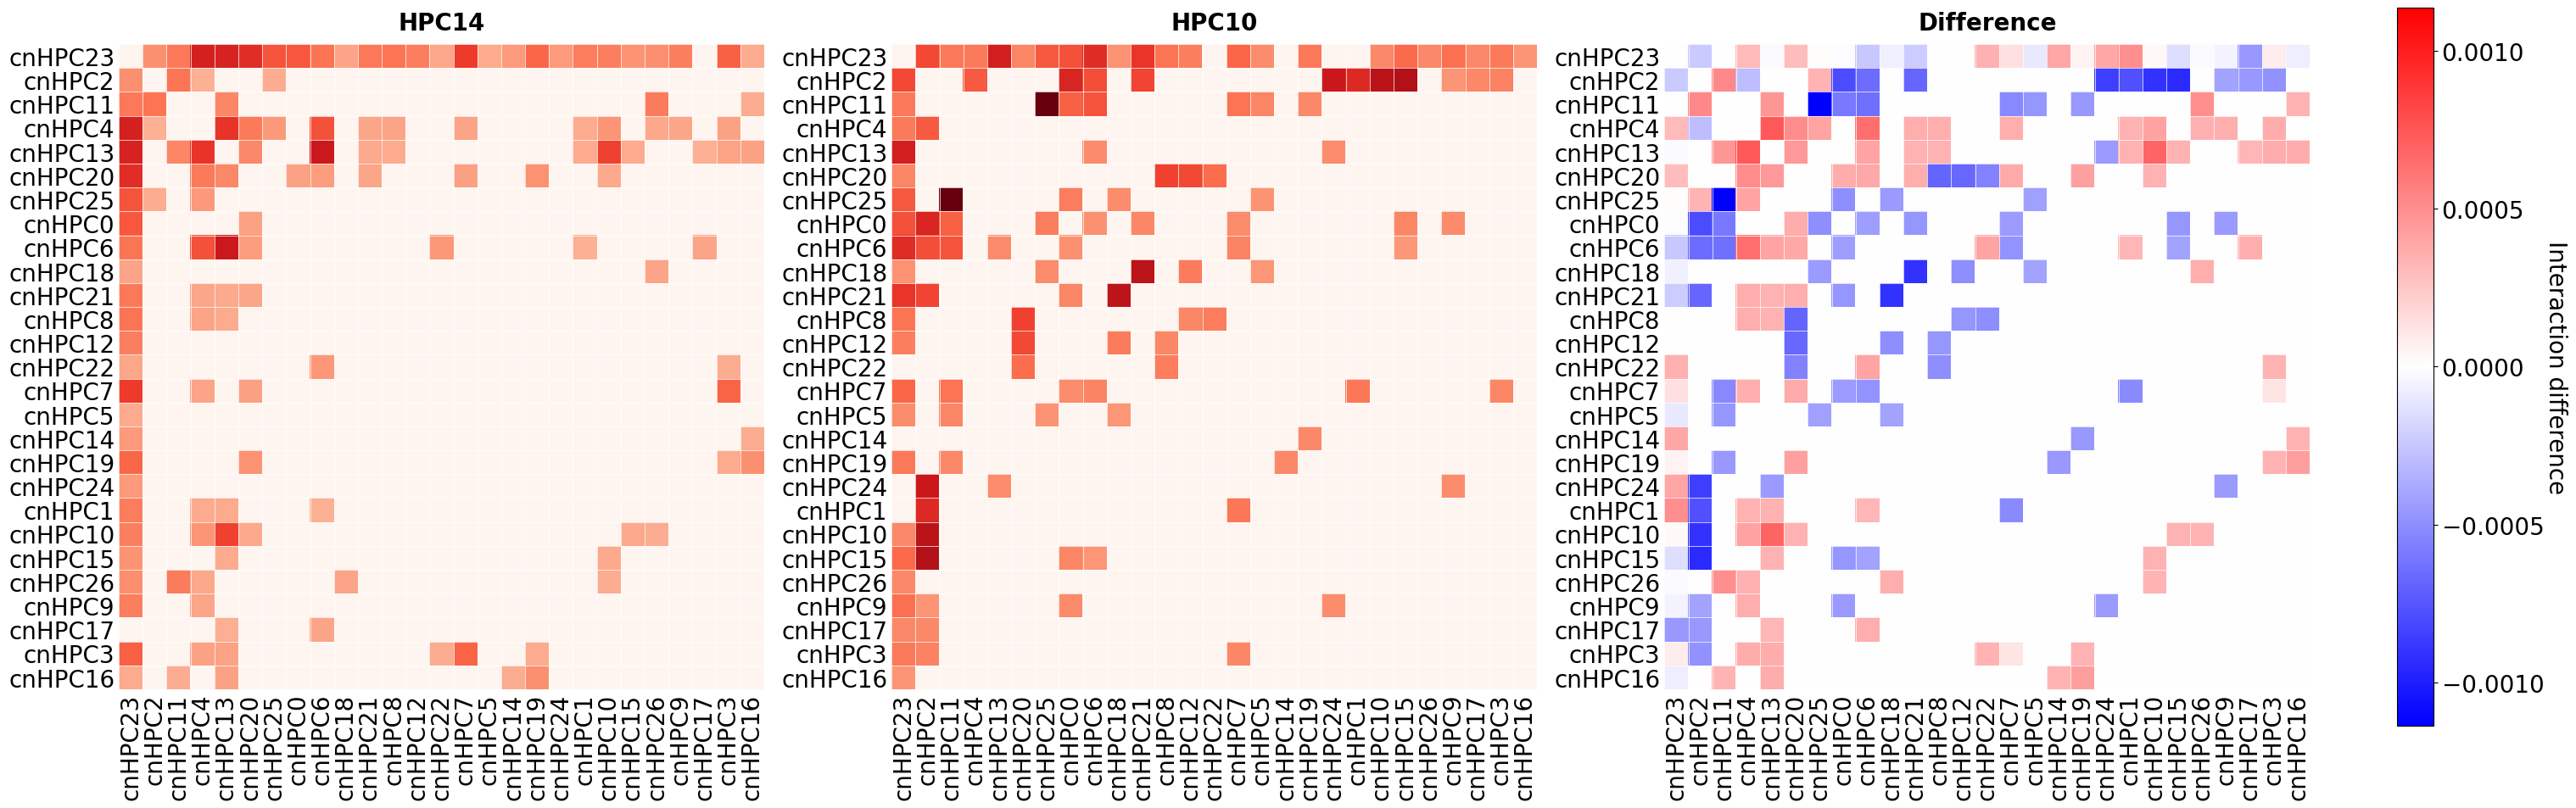

In [14]:
num_tiles_hpc14 = len(df[df.HPC == 14])
num_tiles_hpc10 = len(df[df.HPC == 10])
compare_adjacency_matrices_filtered(
    nodes_hpc14, adj_hpc14/num_tiles_hpc14,
    nodes_hpc10, adj_hpc10/num_tiles_hpc10,
    title1="HPC14", title2="HPC10",
    diff_cmap = custom_cmap)

Dendrogram of all HPC fingerprints.

In [16]:
def plot_clustered_heatmap_for_dendrogram(matrix, cmap="Reds", vmax=None, ax=None):
    """
    Plots a single heatmap without axes. Returns the image handle for colorbar.
    """
    vmax = vmax if vmax is not None else matrix.max()
    im = ax.imshow(matrix, cmap=cmap, vmin=0, vmax=vmax, interpolation="nearest")
    ax.set_axis_off()
    return im

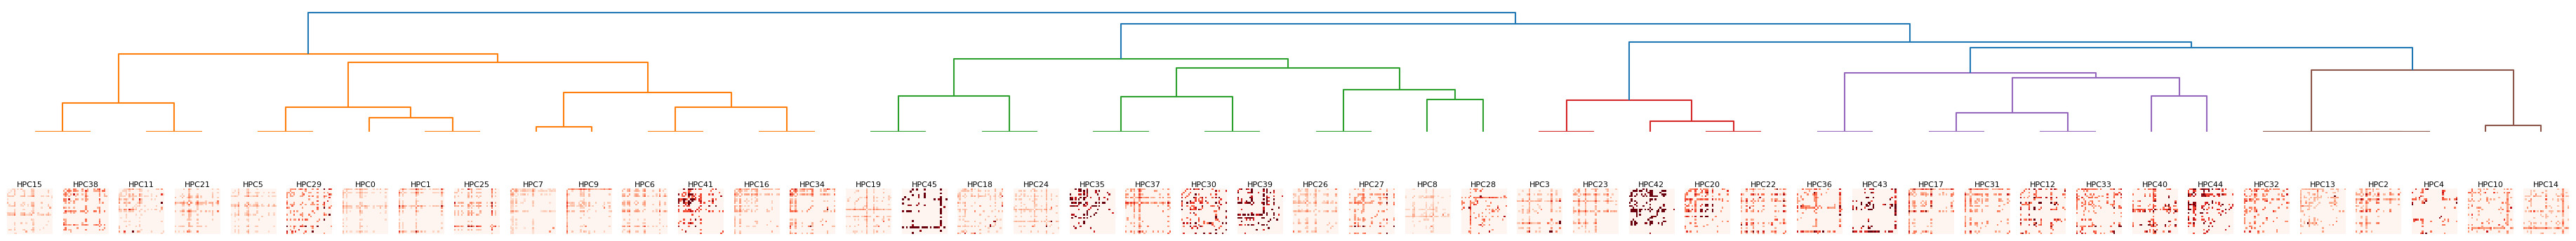

In [20]:
# --- Step 1: Load data and compute dendrogram
adata = sc.read('/gpfs/data/tsirigoslab/home/leh06/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128/luad_overall_survival_nn250/adatas/TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered_leiden_2p0__fold0_subsample_paga.h5ad')
paga_graph = adata.uns['paga']['connectivities']
connectivity_matrix = paga_graph.toarray()
distance_matrix = 1 - connectivity_matrix
condensed_distance_matrix = squareform(distance_matrix, checks=False)
Z = linkage(condensed_distance_matrix, method='ward')

# --- Step 2: Get sorted cluster IDs
hpc_ids = sorted(df.HPC.unique())
num_clusters = len(hpc_ids)

# --- Step 3: Setup figure and gridspec (2 rows: dendrogram, heatmaps, colorbar)
fig = plt.figure(figsize=(num_clusters * 0.8, 5))
gs = fig.add_gridspec(2, num_clusters, height_ratios=[1, 2])

# --- Step 4: Plot dendrogram across top row
ax_dendro = fig.add_subplot(gs[0, :])
dendrogram(Z, ax=ax_dendro)
ax_dendro.set_axis_off()

# --- Step 5: Plot heatmaps
leaf_order = dendrogram(Z, no_plot=True)['leaves']
for j, hpc_id in enumerate(leaf_order):
    nodes_hpc, adj_hpc = run_graph_analysis(hpc_id, df, global_color_map, freq_percentile=80, plot_consensus = False)
    num_cells_hpc = len(df[df.HPC == hpc_id])

    # Save individual heatmap
    fig_single, ax_single = plt.subplots(figsize=(2, 2))
    im = plot_clustered_heatmap_for_dendrogram(matrix=adj_hpc/num_cells_hpc, ax=ax_single, vmax=0.0015)
    ax_single.set_axis_off()
    fig_single.tight_layout()
    # fig_single.savefig(f"./HPC_fingerprint_heatmaps_normalized/heatmap_HPC{hpc_id}.png", dpi=300)
    plt.close(fig_single)  # Avoid memory issues from too many open figures
    
    ax = fig.add_subplot(gs[1, j])
    last_im = plot_clustered_heatmap_for_dendrogram(matrix=adj_hpc/num_cells_hpc, ax=ax, vmax=0.0015)
    ax.set_title(f"HPC{hpc_id}", fontsize=8, pad=2)

# --- Step 7: Display
plt.tight_layout()
plt.show()
# plt.savefig("./HPC_fingerprint_heatmaps_normalized/dendrogram_hpcs.png", dpi=300)